In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Get data

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
# check the files
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
# training folder
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
# check one positive sample
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load data

In [6]:
# remove extra folder to keep only pos and neg folder, necessary for keras.preprocessing.text_dataset_from_directory
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
# create training tf.data.Dataset

batch_size = 32
seed = 42

# raw_train_ds will be a tf.data.Dataset object
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2, # also split some validation set, created later
    subset='training', # specify this invoke is for training set
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
# check some loaded data from tf.data.Dataset
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
# label 0 is neg, 1 is pos
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
# create validation set
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation', # specify this invoke is for validation set
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
# create test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


# Preprocess data

In [12]:
# tf.preprocessing.TextVectorization does not remove html tags, we have to do it
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) # lowercase all text
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove html tags
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [13]:
# a TextVectorization layer standardizes, tokenizes, and vectorizes text data

max_features = 10000
sequence_length = 250 # only keep 250 words per sample

vectorize_layer = TextVectorization(
    standardize=custom_standardization, # use our custom standarize function
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [14]:
# make a text only dataset (without labels), then adapt
# adapt fits the state of the preprocessing layer to the dataset, building an index of strings to integers (vectorization)
# only use adapt on train data
train_text = raw_train_ds.map(lambda x, y: x)  # only keep the text
vectorize_layer.adapt(train_text)

In [15]:
# function to preprocess data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1) # expand dimension at end
    return vectorize_layer(text), label

In [16]:
# test vectorizing a sample

text_batch, label_batch = next(iter(raw_train_ds)) # retrive a batch
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [17]:
# each string token is mapped to an integer (vectorization)
# can use get_vocabulary() to get the actual token
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])

print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
313 --->  american
Vocabulary size: 10000


In [18]:
# add TextVectorization layer to train, val, test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
# cache() and prefetch() improves efficiency of datasets

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create model

In [20]:
embedding_dim = 16

# Embedding layer converts word-index into embedding vectors, adds a dimension, (batch, sequence, embedding)
# GlobalAveragePooling1D layer averages the sequence dimension, returning a fixed length vector for each sample, this is to handle inputs of different length

model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1) # positive or negative probability
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [21]:
# compile model with cost function and optimizer
# use BinaryCrossentropy because binary classifcation and model outputs a probablity (single unit output with sigmoid activation)
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train model

In [22]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 16s 26ms/step - loss: 0.6603 - binary_accuracy: 0.6949 - val_loss: 0.6087 - val_binary_accuracy: 0.7756
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5431 - binary_accuracy: 0.8056 - val_loss: 0.4935 - val_binary_accuracy: 0.8244
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4406 - binary_accuracy: 0.8474 - val_loss: 0.4171 - val_binary_accuracy: 0.8490
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3746 - binary_accuracy: 0.8687 - val_loss: 0.3717 - val_binary_accuracy: 0.8618
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3336 - binary_accuracy: 0.8793 - val_loss: 0.3434 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3039 - binary_accuracy: 0.8906 - val_loss: 0.3247 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

# Evaluate model

In [23]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 15s 20ms/step - loss: 0.3099 - binary_accuracy: 0.8740
Loss:  0.30989956855773926
Accuracy:  0.8740400075912476


In [24]:
# check training history, it contains loss, accuracy, val_loss, val_accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

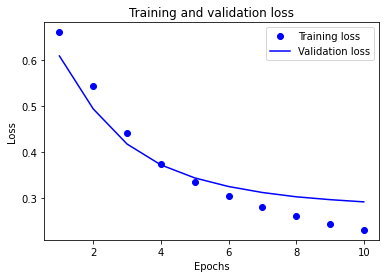

In [25]:
# plot loss and acc over time

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# plot loss
plt.plot(epochs, loss, 'bo', label='Training loss') # bo = blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b = blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

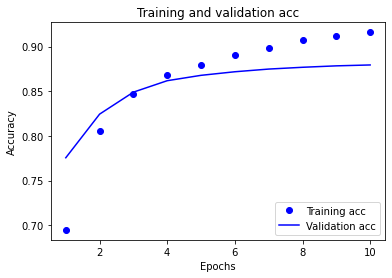

In [26]:
# plot accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# some overfitting

# Export model

In [27]:
# add the Textvectorization layer to the model to export it, so that it can take raw text inputs, it will use previous model's trained weights
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

# test with raw text inputs
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

# keeping TextVectorization layer outside the model can use async CPU porcessing, it is good for training
# only include in model when exporting

782/782 [==============================] - 19s 24ms/step - loss: 0.3099 - accuracy: 0.8740
0.8740400075912476
